# Probabilistic Numerical Methods

Probabilistic numerical methods solve numerical tasks by treating them as problems of statistical inference. This approach captures uncertainty arising from finite computational resources and from stochastic input.

In order to illustrate what PN methods are and how they work consider the following deliberately simple numerical problem.

In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../probnum.mplstyle')

## A Simple Numerical Problem

Suppose we are trying to find the minimum of a one-dimensional quadratic function $$\underset{x}{\operatorname{argmin}} f(x) = \underset{x}{\operatorname{argmin}} \frac{1}{2} x^2 + bx + c.$$ Since $f$ is a strictly convex function there exists a unique minimum $x_*$. We can even analytically compute the solution $x_*=-b$ by setting $f'(x_*) = 0$.

In [75]:
import numpy as np
import probnum as pn

# Quadratic objective function
b = -1.0
c = 3.0
x_opt = -b

def f(x):
    return 0.5 * x ** 2 + b * x + c

Now suppose we are not given access to the coefficients, but only the ability to evaluate $f$ and its derivative $f'$ at arbitrary points. We can then use a numerical method such as gradient descent to solve the problem. 

However, what happens if we go one step further and assume these function evaluations are corrupted by noise? This is often the case in practice where $f$ might describe a complex physical system or a simulation depending on data. Can we still design an efficient algorithm which finds the minimum?

## One-Dimensional Noisy Quadratic Optimization

Suppose now that we only have access to noisy evaluations $$\hat{y} = \hat{f}(x) = \frac{1}{2}x^2 + (b+\varepsilon_b)x + (c + \varepsilon_c)$$  of the objective function $f$ at $x$, where $\varepsilon = (\varepsilon_b, \varepsilon_c) \sim \mathcal{N}(0, \Sigma)$.

*Remark*: The $n$-dimensional analogue of this case arises for example in supervised learning. In large-scale empirical risk minimization the available training data often does not fit into (local) memory, so during optimization only batches of data are considered inducing noise on the objective function and its gradient. Here $\hat{f}$ would correspond to the empirical risk on the current batch.

In [79]:
from probnum.prob import RandomVariable, Normal

# Noisy objective function
Sigma = np.diag([0.05, 0.1])
eps = RandomVariable(distribution=Normal(np.zeros(2), Sigma))

def f_hat(x, noise=eps.sample(1)):
    return 0.5 * x ** 2 + (b + noise[0]) * x + c + noise[1]

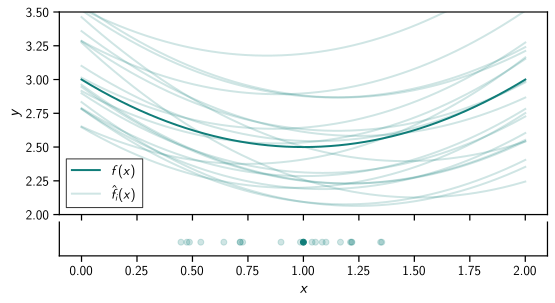

In [82]:
# Random seed
np.random.seed(1)

# Plot objective and noisy evaluations
xx = np.linspace(0, 2, 1000)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [6, 1]})
axes[0].plot(xx, f(xx), label="$f(x)$")
axes[1].scatter(x_opt, 0)
for i in range(20):
    noise = eps.sample(1)
    x_opt_noise = -(b + noise[1])
    if i == 0:
        sample_label = "$\\hat{f}_i(x)$"
    else:
        sample_label = None
    axes[0].plot(xx, f_hat(xx, noise), color="C0", alpha=0.2, label=sample_label)
    axes[1].scatter(x_opt_noise, 0, color="C0", alpha=0.2)

axes[1].get_yaxis().set_visible(False)
axes[1].spines["top"].set_visible(False)
ylim0 = [2, 3.5]
ylim1 = [-0.75, 1.1]
axes[0].set_ylim(ylim0)
axes[1].set_ylim(ylim1)
axes[0].set_ylabel("$y$")
axes[1].set_xlabel("$x$")
axes[0].legend()
plt.tight_layout(h_pad=0)
plt.show()

This makes the optimization problem considerably more difficult depending on the degree of noise. How can we design a computationally efficient and accurate algorithm that makes use of the information we have about the problem?

## Designing a Probabilistic Numerical Method

A naive strategy to solve the problem given only the ability to evaluate the noisy function $\hat{f}$ could be to simply choose random points on the real axis and return the point of lowest observed function value. However, clearly this is suboptimal since it completely ignores information we have and collect about the problem. For example we know we are trying to solve a latent quadratic problem. 

Suppose we have some idea of where the minimum of the function $f$ lies or an idea about what coefficients of the quadratic function are likely. This could come from experience, a physical application from which the problem arises or related optimization problems we have solved in the past. Then we should evaluate closer to where we belief the  optimum is.

We would like to use this prior information to solve the optimization problem in question. In order to do so we need to collect information about the problem, which we do by evaluating $\hat{f}$ at chosen points $x$. The decision of where to evaluate is called a _policy_. 

We now want to design a _probabilistic numerical method_ to solve the above problem. 

### Prior

In [86]:
# Prior knowledge encoded in random variable
x_opt0 = RandomVariable(distribution=Normal(1.5, 0.1))

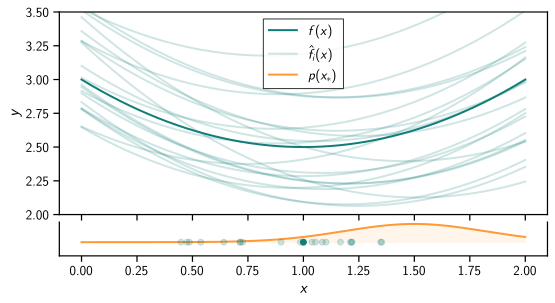

In [87]:
# Random seed
np.random.seed(1)

# Plot objective, noisy evaluations and belief over minimum
x0_pdf = x_opt0.distribution.pdf(xx)
x0_pdf_max = np.max(x0_pdf)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [6, 1]})
axes[0].plot(xx, f(xx), label="$f(x)$")
axes[1].fill_between(xx, y1=x0_pdf / x0_pdf_max , color="C1", alpha=0.1, zorder=-1)
axes[1].plot(xx, x0_pdf / x0_pdf_max, color="C1", label="$p(x_*)$", zorder=-1)
axes[1].scatter(x_opt, 0)
for i in range(20):
    noise = eps.sample(1)
    x_opt_noise = -(b + noise[1])
    if i == 0:
        sample_label = "$\\hat{f}_i(x)$"
    else:
        sample_label = None
    axes[0].plot(xx, f_hat(xx, noise), color="C0", alpha=0.2, label=sample_label)
    axes[1].scatter(x_opt_noise, 0, color="C0", alpha=0.2)

axes[1].get_yaxis().set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[0].set_ylim(ylim0)
axes[1].set_ylim(ylim1)
axes[0].set_ylabel("$y$")
axes[1].set_xlabel("$x$")
handles, labels = [(a + b) for a, b in zip(axes[0].get_legend_handles_labels(), 
                                           axes[1].get_legend_handles_labels())]
axes[0].legend(handles, labels, loc="upper center")
plt.tight_layout(h_pad=0)
plt.show()

### Policy

In order to collect information about the problem we need to decide where to evaluate the (noisy) objective function $\hat{f}$. This is done via a _policy_ $\pi$. In principle this can be any function which maps to the domain of $\hat{f}$, however it is sensible to use the model of the problem our algorithm is building resulting in a model-based policy.

In [8]:
def random_walk_policy(x_opt0, region=(-1.5, 1.5)):
    """A uniform sampling policy."""
    return np.random.uniform(low=region[0], high=region[1])

def greedy_policy(x_opt0):
    """Greedy model-based policy."""
    return x_opt0.distribution.mean()
                  
def sampling_policy(x_opt0):
    """Sampling model-based policy."""
    return x_opt0.sample(1)[0]              

In [9]:
print(f"Suggested evaluation points by random walk {random_walk_policy(x_opt0):.2f}, greedy {greedy_policy(x_opt0):.2f} and a sampling model-based policy {sampling_policy(x_opt0):.2f}.")

Suggested evaluation points by random walk -0.55, greedy 1.20 and a sampling model-based policy 1.82.


### Action and Observation

We now use our policy to collect observations about the problem by evaluating the objective function at the suggested evaluation point(s).

In [42]:
def observe(f, x_eval):
    """Make observation about numerical problem."""
    return f(x_eval)

### Inference Step

Given the noise model we can compute the distribution of the random variable $f(x)$ for a given evaluation point $x$ using the properties of Gaussians $$\hat{y} \sim \mathcal{N}\bigg(f(x), \begin{pmatrix}x^2 & x & 1 \end{pmatrix}\Sigma \begin{pmatrix}x^2 \\ x\\1 \end{pmatrix}\bigg).$$

By Gaussian inference rules this results in the posterior
$$
p(x \mid y) = \mathcal{N}\bigg( \bigg)
$$

### Stopping Criteria

In [57]:
def stopping_criterion(x, current_iter, maxiter=100, tol=10**-6):
    """Convergence criteria."""
    return current_iter >= maxiter or x.distribution.cov() < tol

### Putting It All Together

In [68]:
def probsolve_qp(f, x_opt0, policy=sampling_policy, stopping_criterion=stopping_criterion):
    """
    Probabilistic Quadratic Optimization.
    
    PN method solving unconstrained one-dimensional (noisy) quadratic 
    optimization problems only needing access to function evaluations.
    """
    iteration = 0
    # Iterate until stopping criterion
    while not stopping_criterion(x_opt0, iteration):
        
        # Policy
        x_eval = policy(x_opt0)
        print(f"evaluation point: {x_eval:.2f}")
        
        # Observation
        y = observe(f, x_eval)
        print(f"function value: {y:.2f}")
        
        # Inference
        mean_updated = x_opt0.distribution.mean()
        cov_updated = x_opt0.distribution.cov() / 1.5
        x_opt0 = RandomVariable(distribution=Normal(mean_updated, cov_updated))
        
        iteration += 1
        
    return x_opt0

In [67]:
x_sol = probsolve_qp(f_hat, x_opt0)

evaluation point: 1.60
function value: 3.96
evaluation point: 1.71
function value: 4.23
evaluation point: 0.81
function value: 2.93
evaluation point: 1.41
function value: 3.55
evaluation point: 1.43
function value: 3.58
evaluation point: 1.24
function value: 3.27
evaluation point: 1.09
function value: 3.09
evaluation point: 1.27
function value: 3.31
evaluation point: 1.19
function value: 3.20
evaluation point: 1.17
function value: 3.18
evaluation point: 1.15
function value: 3.15
evaluation point: 1.22
function value: 3.24
evaluation point: 1.22
function value: 3.24
evaluation point: 1.19
function value: 3.20
evaluation point: 1.21
function value: 3.23
evaluation point: 1.18
function value: 3.19
evaluation point: 1.21
function value: 3.23
evaluation point: 1.20
function value: 3.22
evaluation point: 1.20
function value: 3.21
evaluation point: 1.20
function value: 3.21
evaluation point: 1.20
function value: 3.22
evaluation point: 1.20
function value: 3.22
evaluation point: 1.20
function 

## Outlook

- Probabilistic Linear Solver
- Bayesian Optimization
- Quadrature


- Development Tutorial